### This notebook shows how to use recurrent neural network for multi-step forecast of power consumption.

In [39]:
import sys
import numpy as np
import pandas as pd

from datetime import timedelta as td
import dateutil.parser

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [40]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'])

# sort dataframe
df = df.sort_values(by='Datetime').reset_index(drop=True)

df.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


In [41]:
df.tail()

,Datetime,EKPC_MW
45329,2018-08-02 20:00:00,1815.0
45330,2018-08-02 21:00:00,1769.0
45331,2018-08-02 22:00:00,1756.0
45332,2018-08-02 23:00:00,1619.0
45333,2018-08-03 00:00:00,1448.0


# Explore data

In [42]:
print(df.shape) # shape
print()
print(df.info()) # general info
print()
df.isna().sum() # missing values

(45334, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
Datetime    45334 non-null datetime64[ns]
EKPC_MW     45334 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.4 KB
None



Datetime    0
EKPC_MW     0
dtype: int64

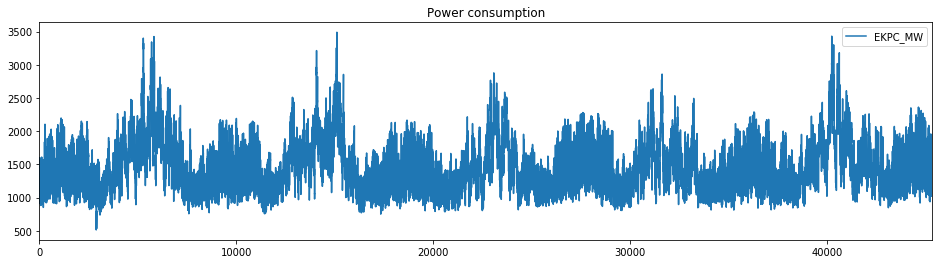

In [43]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Create pipeline

In [44]:
# Custom Transformer: Encode calendar data
class DatetimeProcessor(BaseEstimator, TransformerMixin):
    # Class Constructor 
    def __init__(self):
        pass
    
    # Return self nothing else to do here    
    def fit(self, X, y=None):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return np.concatenate([X['Datetime'].apply(lambda x: x.month).values.reshape(-1,1), 
                               X['Datetime'].apply(lambda x: x.day).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.weekday()).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.hour).values.reshape(-1,1)], axis=1)

# preprocessing pipeline
feature_transformer = Pipeline(steps=[('calendar', DatetimeProcessor()),
                                      ('onehot', OneHotEncoder(sparse=False))])

# transformer for scaling target variable
target_transformer = MinMaxScaler(feature_range=(0.1, 4.1))

# Split data

In [45]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[df.Datetime < dateutil.parser.parse("2016-01-01")]
df_valid = df[(df.Datetime >= dateutil.parser.parse("2016-01-01")) & (df.Datetime < dateutil.parser.parse("2017-01-01"))]
df_test = df[df.Datetime >= dateutil.parser.parse("2017-01-01")]

# numpy data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22654, 74) y_train = (22654, 1)
X_valid = (8784, 74) y_valid = (8784, 1)
X_test = (13896, 74) y_test = (13896, 1)


In [46]:
# organize data in a way suitable for tensorflow model
def get_data_model(x_vals, y_vals, Tx=24, Ty=24):

    x_encoder, y_encoder, x_decoder, y_decoder = [], [], [], []
    
    for i in range(Tx+1, x_vals.shape[0]-Ty):
        x = x_vals[i-Tx:i, :]
        y = y_vals[i-1-Tx:i-1].reshape(-1, 1)
        f = np.concatenate((x, y), axis=1)
        
        x_encoder.append(f)
        y_encoder.append(y_vals[i-Tx:i])
        
        x_decoder.append(x_vals[i:i+Ty,:])
        y_decoder.append(y_vals[i:i+Ty])    
   
    # convert to numpy arrays
    x_encoder = np.array(x_encoder)
    y_encoder = np.array(y_encoder)
    y_encoder = np.expand_dims(y_encoder, axis=2)
    
    x_decoder = np.array(x_decoder)
    y_decoder = np.array(y_decoder)    
    y_decoder = np.expand_dims(y_decoder, axis=2)
    
    return [x_encoder, y_encoder, x_decoder, y_decoder]

# get data sets in numpy arrays
x_encoder_train, y_encoder_train, x_decoder_train, y_decoder_train = get_data_model(X_train, y_train)
x_encoder_valid, y_encoder_valid, x_decoder_valid, y_decoder_valid = get_data_model(X_valid, y_valid)
x_encoder_test, y_encoder_test, x_decoder_test, y_decoder_test = get_data_model(X_test, y_test)

# data for tensorflow
x_train_tf, y_train_tf = [x_encoder_train, x_decoder_train], np.squeeze(y_decoder_train)
x_valid_tf, y_valid_tf = [x_encoder_valid, x_decoder_valid], np.squeeze(y_decoder_valid)
x_test_tf, y_test_tf = [x_encoder_test, x_decoder_test], np.squeeze(y_decoder_test)

# print shape of array
print('x_encoder_train.shape = ', x_encoder_train.shape)
print('y_encoder_train.shape = ', y_encoder_train.shape)
print('x_decoder_train.shape = ', x_decoder_train.shape)
print('y_decoder_train.shape = ', y_decoder_train.shape)
print()
print('x_encoder_valid.shape = ', x_encoder_valid.shape)
print('y_encoder_valid.shape = ', y_encoder_valid.shape)
print('x_decoder_valid.shape = ', x_decoder_valid.shape)
print('y_decoder_valid.shape = ', y_decoder_valid.shape)
print()
print('x_encoder_test.shape = ', x_encoder_test.shape)
print('y_encoder_test.shape = ', y_encoder_test.shape)
print('x_decoder_test.shape = ', x_decoder_test.shape)
print('y_decoder_test.shape = ', y_decoder_test.shape)

x_encoder_train.shape =  (22605, 24, 75)
y_encoder_train.shape =  (22605, 24, 1, 1)
x_decoder_train.shape =  (22605, 24, 74)
y_decoder_train.shape =  (22605, 24, 1, 1)

x_encoder_valid.shape =  (8735, 24, 75)
y_encoder_valid.shape =  (8735, 24, 1, 1)
x_decoder_valid.shape =  (8735, 24, 74)
y_decoder_valid.shape =  (8735, 24, 1, 1)

x_encoder_test.shape =  (13847, 24, 75)
y_encoder_test.shape =  (13847, 24, 1, 1)
x_decoder_test.shape =  (13847, 24, 74)
y_decoder_test.shape =  (13847, 24, 1, 1)


# Build tensorflow model

## Architecture: sequence to sequence (Seq2Seq) 

The model consists of encoder and decoder
<!--- 

-->
<img src="images/energy/seq2seq.png" width="1000" height="700" style="float: center"/>

In [47]:
def build_model(nx_encoder, nx_decoder, Tx=24, Ty=24):
    """
    params:
    nx_encoder - number of features in encoder
    nx_decoder - number of features in decoder
    Tx - length of input sequence
    Ty - length of output sequence
    """

    # inputs
    x_encoder = Input(shape=(Tx, nx_encoder))
    x_decoder = Input(shape=(Ty, nx_decoder))

    # number of hidden units
    num_units = [128, 64]
    
    # II - ENCODER TRANSFORMATIONS
    x1 = x_encoder
    states = []
    for n_units in num_units:        
        #o, h, c = LSTM(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001))(x1)        
        #states.append([h, c])        
        o, h = GRU(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001))(x1)
        states.append(h)
        x1 = o
        
    y_encoder = Dense(1, activation='linear')(x1) # for pretraining
    
    # III - DECODER TRANSFORMATIONS
    x2 = x_decoder
    for i, n_units in enumerate(num_units):           
        #o = LSTM(n_units, return_sequences=True, kernel_regularizer=reg_l2(0.001))(x2, initial_state=states[i])
        o = GRU(n_units, return_sequences=True, kernel_regularizer=reg_l2(0.001))(x2, initial_state=states[i])
        x2 = o        
        
    y_decoder = Dense(1, activation='linear')(x2)
    
    # IV -models
    model = {}
    model['encoder'] = Model(inputs=x_encoder, outputs=y_encoder)
    model['encoder'].compile(optimizer='adam', loss='mse')
    
    model['encoder_decoder'] = Model(inputs=[x_encoder, x_decoder], outputs=y_decoder)    
    model['encoder_decoder'].compile(optimizer='adam', loss='mse')
    
    return model


# model
seq2seq = build_model(nx_encoder=x_encoder_train.shape[2], nx_decoder=x_decoder_train.shape[2])
seq2seq['encoder_decoder'].summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24, 75)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 24, 74)]     0                                            
__________________________________________________________________________________________________
gru_12 (GRU)                    [(None, 24, 128), (N 78720       input_5[0][0]                    
__________________________________________________________________________________________________
gru_14 (GRU)                    (None, 24, 128)      78336       input_6[0][0]                    
                                                                 gru_12[0][1]         

## Train the model

### First pretrain encoder

In [48]:
fname_best_encoder = 'models/energy/multistep/seq2seq/encoder/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_encoder,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train encoder
seq2seq['encoder'].fit(x_encoder_train, np.squeeze(y_encoder_train),
                       validation_data=(x_encoder_valid, np.squeeze(y_encoder_valid)), epochs=30, shuffle=False, callbacks=callbacks)

Epoch 1/30
707/707 [==============================] - ETA: 0s - loss: 0.1425
Epoch 00001: val_loss improved from inf to 0.10036, saving model to models/energy/multistep/seq2seq/encoder\best
707/707 [==============================] - 21s 29ms/step - loss: 0.1425 - val_loss: 0.1004
Epoch 2/30
705/707 [============================>.] - ETA: 0s - loss: 0.0558
Epoch 00002: val_loss improved from 0.10036 to 0.05179, saving model to models/energy/multistep/seq2seq/encoder\best
707/707 [==============================] - 17s 24ms/step - loss: 0.0557 - val_loss: 0.0518
Epoch 3/30
706/707 [============================>.] - ETA: 0s - loss: 0.0360
Epoch 00003: val_loss improved from 0.05179 to 0.03742, saving model to models/energy/multistep/seq2seq/encoder\best
707/707 [==============================] - 17s 23ms/step - loss: 0.0360 - val_loss: 0.0374
Epoch 4/30
705/707 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00004: val_loss improved from 0.03742 to 0.02438, saving model to 

### Next train encoder-decoder model

In [49]:
fname_best_seq2seq = 'models/energy/multistep/seq2seq/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_seq2seq,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# Load pretrained encoder
seq2seq['encoder'].load_weights(fname_best_encoder)

# train encoder-decoder model
history = seq2seq['encoder_decoder'].fit(x_train_tf, y_train_tf, 
                                         validation_data=(x_valid_tf, y_valid_tf), epochs=70, shuffle=False, callbacks=callbacks)

# Load the weights with the best error on validation data
seq2seq['encoder_decoder'].load_weights(fname_best_seq2seq)

Epoch 1/70
706/707 [============================>.] - ETA: 0s - loss: 0.2489
Epoch 00001: val_loss improved from inf to 0.26183, saving model to models/energy/multistep/seq2seq\best
707/707 [==============================] - 27s 38ms/step - loss: 0.2488 - val_loss: 0.2618
Epoch 2/70
707/707 [==============================] - ETA: 0s - loss: 0.1598
Epoch 00002: val_loss improved from 0.26183 to 0.22561, saving model to models/energy/multistep/seq2seq\best
707/707 [==============================] - 27s 38ms/step - loss: 0.1598 - val_loss: 0.2256
Epoch 3/70
707/707 [==============================] - ETA: 0s - loss: 0.1308
Epoch 00003: val_loss improved from 0.22561 to 0.18601, saving model to models/energy/multistep/seq2seq\best
707/707 [==============================] - 26s 37ms/step - loss: 0.1308 - val_loss: 0.1860
Epoch 4/70
706/707 [============================>.] - ETA: 0s - loss: 0.1117
Epoch 00004: val_loss improved from 0.18601 to 0.15927, saving model to models/energy/multistep/

Epoch 33/70
707/707 [==============================] - ETA: 0s - loss: 0.0463
Epoch 00033: val_loss did not improve from 0.07098
707/707 [==============================] - 26s 37ms/step - loss: 0.0463 - val_loss: 0.0720
Epoch 34/70
707/707 [==============================] - ETA: 0s - loss: 0.0457
Epoch 00034: val_loss improved from 0.07098 to 0.07078, saving model to models/energy/multistep/seq2seq\best
707/707 [==============================] - 27s 38ms/step - loss: 0.0457 - val_loss: 0.0708
Epoch 35/70
707/707 [==============================] - ETA: 0s - loss: 0.0486
Epoch 00035: val_loss did not improve from 0.07078
707/707 [==============================] - 28s 39ms/step - loss: 0.0486 - val_loss: 0.0732
Epoch 36/70
706/707 [============================>.] - ETA: 0s - loss: 0.0450
Epoch 00036: val_loss did not improve from 0.07078
707/707 [==============================] - 26s 37ms/step - loss: 0.0450 - val_loss: 0.0713
Epoch 37/70
706/707 [============================>.] - ETA: 0s

Epoch 70/70
707/707 [==============================] - ETA: 0s - loss: 0.0323
Epoch 00070: val_loss did not improve from 0.06962
707/707 [==============================] - 28s 40ms/step - loss: 0.0323 - val_loss: 0.0824


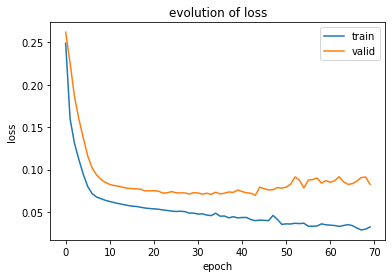

In [50]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [51]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model = seq2seq['encoder_decoder']

# train data
y_train_true = y_decoder_train.squeeze()
y_train_pred = model.predict(x_train_tf).squeeze()
print("Train data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_train_true, y_train_pred),
                                                  mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = y_decoder_valid.squeeze()
y_valid_pred = model.predict(x_valid_tf).squeeze()
print("Valid data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_valid_true, y_valid_pred),
                                                  mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = y_decoder_test.squeeze()
y_test_pred = model.predict(x_test_tf).squeeze()
print("Test data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_test_true, y_test_pred),
                                                 mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MSE=0.0432 MAPE=11.2318
Valid data: MSE=0.0599 MAPE=12.4168
Test data: MSE=0.0632 MAPE=12.6393


## Plot individual 24-hour forecasts

In [52]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

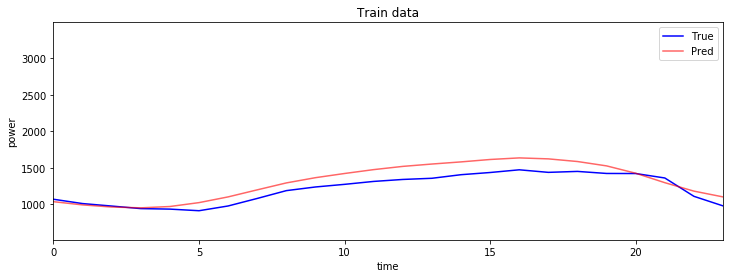

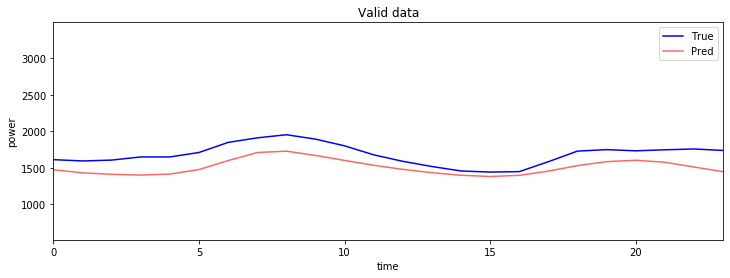

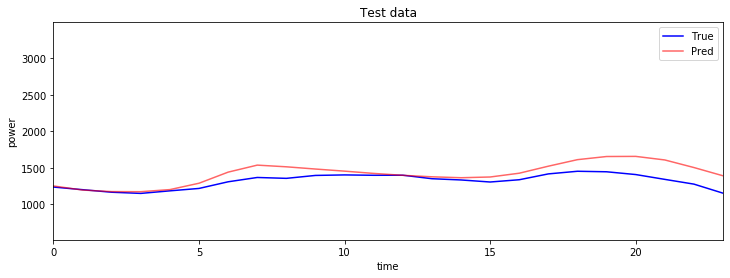

In [53]:
idx = 0 # index of example in a dataset

y_true = target_transformer.inverse_transform( y_train_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_train_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Train data", ylim=ylim)

y_true = target_transformer.inverse_transform( y_valid_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_valid_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Valid data", ylim=ylim)

y_true = target_transformer.inverse_transform( y_test_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_test_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Test data", ylim=ylim)

## Plot all 24-hour forecasts concatenating the results 

In [54]:
# concatenate all true values and all predictions

# true values
y_all_train_true = target_transformer.inverse_transform( y_train_true.flatten().reshape(-1, 1) )
y_all_valid_true = target_transformer.inverse_transform( y_valid_true.flatten().reshape(-1, 1) )
y_all_test_true = target_transformer.inverse_transform( y_test_true.flatten().reshape(-1, 1) )

# predicted values
y_all_train_pred = target_transformer.inverse_transform( y_train_pred.flatten().reshape(-1, 1) )
y_all_valid_pred = target_transformer.inverse_transform( y_valid_pred.flatten().reshape(-1, 1) )
y_all_test_pred = target_transformer.inverse_transform( y_test_pred.flatten().reshape(-1, 1) )

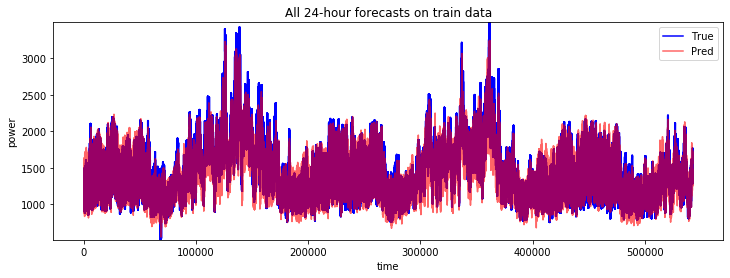

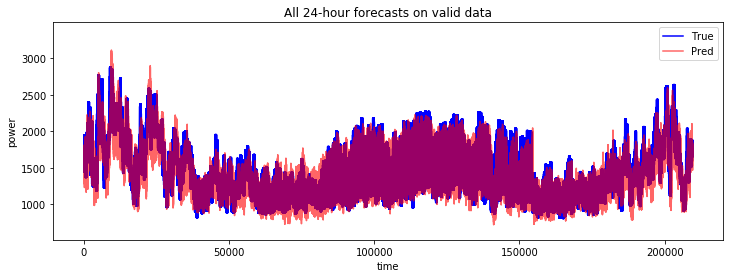

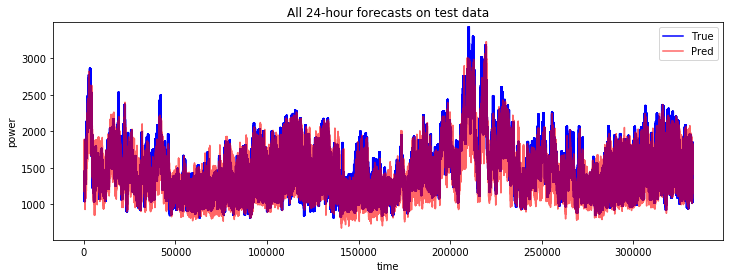

In [55]:
# plot the results
plot_predictions(y_all_train_true, y_all_train_pred, title='All 24-hour forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_all_valid_true, y_all_valid_pred, title='All 24-hour forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_all_test_true, y_all_test_pred, title='All 24-hour forecasts on test data', xlim=None, ylim=ylim)


## Plot mean absolute percentage error (MAPE) at different time steps

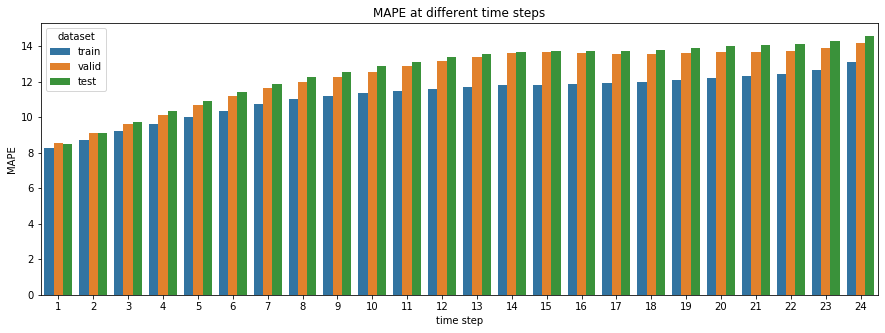

In [57]:
# compute errors
errros_train = [mean_absolute_percentage_error(y_train_true[:,i], y_train_pred[:,i]) for i in range(24)]
errros_valid = [mean_absolute_percentage_error(y_valid_true[:,i], y_valid_pred[:,i]) for i in range(24)]
errros_test = [mean_absolute_percentage_error(y_test_true[:,i], y_test_pred[:,i]) for i in range(24)]

# plot errors
x = list(range(1,25))*3
y = ['train']*24 + ['valid']*24 + ['test']*24
z = errros_train + errros_valid + errros_test
df_mape = pd.DataFrame(data=zip(x, y, z), columns=['time step', 'dataset', 'MAPE'])
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=df_mape, x='time step', hue='dataset', y='MAPE')
ax.set_title('MAPE at different time steps')
plt.show()